<a href="https://colab.research.google.com/github/vrkh1996/SAT_SAM/blob/main/sam_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code includes in part the use of the `Language Segment-Anything (LangSAM)` package. Developed by Engineer Luca Medeiros, LangSAM is an open-source project designed to combine the capabilities of instance segmentation and text prompts for generating masks for specific objects in images. Here, we modified it so it can perform multiple segmentations on remote sensing imagery.

LangSAM is built upon the Meta model and the `segment-anything` repository. Furthermore, it uses the GroundingDINO detection model, providing a comprehensive and effective tool for object detection and image segmentation.

The LangSAM package is user-friendly and designed to streamline and simplify the process of object detection and image segmentation.

For more comprehensive information, further details, and examples on how to use LangSAM, you can visit Luca Medeiros's GitHub page at https://github.com/luca-medeiros/lang-segment-anything.

---
For those not running this on Google Colab, please ensure you have correctly installed GroundingDINO. You'll need Microsoft C++ Build Tools and Git. Follow the steps below:

1. **Microsoft C++ Build Tools**: Install this software, which provides the tools necessary for compiling and linking C++ code, by visiting [this link](https://visualstudio.microsoft.com/visual-cpp-build-tools/).

2. **Git**: Git is a distributed version control system that's used to track changes in source code during software development. Install it from the official Git website: [https://git-scm.com/](https://git-scm.com/).

    - During the installation process, ensure you select the option to add Git to your system's PATH environment variable. This allows you to run Git commands from the command prompt or terminal on your system.

After successfully installing these tools, you may need to restart your computer to ensure all changes take effect. This will facilitate the successful installation and functioning of GroundingDINO on your local environment.

### Setup

In [ ]:
# Install the necessary libraries
!pip install rasterio geopandas fiona shapely torch torchvision segment-anything huggingface_hub datasets\
    -U git+https://github.com/IDEA-Research/GroundingDINO.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-w22bs4i8
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-w22bs4i8
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 31aa788a3cf6ab82d27385f39e242b34af9cc011
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import required libraries
import os
import numpy as np
import torch
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import groundingdino.datasets.transforms as T
from PIL import Image
from rasterio.plot import show
from matplotlib.patches import Rectangle
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from huggingface_hub import hf_hub_download
from segment_anything import sam_model_registry
from segment_anything import SamPredictor
from shapely.geometry import shape
from rasterio.features import shapes
from datasets import load_dataset
from pycocotools import mask as coco_mask

/usr/local/lib/python3.10/dist-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


### Load Data

In [ ]:
dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset satellite-building-segmentation downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___satellite-building-segmentation/mini/1.0.0/2d4f5155d8a688bdff0915214924fbee078bcc85eb80f4d3c5884b8e319ec0ea. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

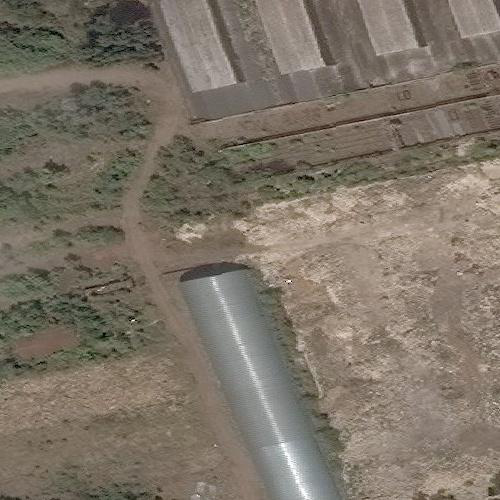

In [ ]:
example = dataset['train'][2]
example["image"]

In [ ]:
def get_segmentation_mask(segmentation_label):
    # Convert COCO segmentation label to binary mask
    binary_mask= np.zeros((500, 500, 1))
    for seg_lbl in segmentation_label['segmentation']:
        rle = coco_mask.frPyObjects(seg_lbl, 500, 500)
        binary_mask += coco_mask.decode(rle)
    
    return binary_mask

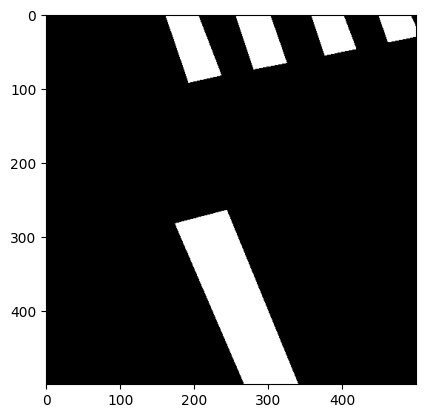

In [ ]:
mask = get_segmentation_mask(dataset["train"]["objects"][0])
plt.imshow(mask, cmap="gray")

In [ ]:
def show_bounding_boxes(image, bounding_boxes):
    # Create a figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot bounding boxes
    for bbox in bounding_boxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Configure plot settings
    ax.axis('off')
    plt.show()

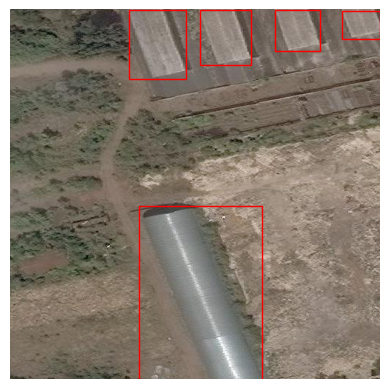

In [ ]:
show_bounding_boxes(dataset["train"]["image"][0], dataset["train"]["objects"][0]['bbox'])

### Model

In [ ]:
# Define constants
SAM_MODELS = {
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
}

# Default cache path for model checkpoints
CACHE_PATH = os.environ.get("TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints"))

In [ ]:
# Define helper functions
def load_model_hf(repo_id: str, filename: str, ckpt_config_filename: str, device: str = 'cpu') -> torch.nn.Module:
    """
    Loads a model from HuggingFace Model Hub.

    Parameters:
    repo_id (str): Repository ID on HuggingFace Model Hub.
    filename (str): Name of the model file in the repository.
    ckpt_config_filename (str): Name of the config file for the model in the repository.
    device (str): Device to load the model onto. Default is 'cpu'.

    Returns:
    torch.nn.Module: The loaded model.
    """
    # Ensure the repo ID and filenames are valid
    assert isinstance(repo_id, str) and repo_id, "Invalid repository ID"
    assert isinstance(filename, str) and filename, "Invalid model filename"
    assert isinstance(ckpt_config_filename, str) and ckpt_config_filename, "Invalid config filename"
    
    # Download the config file and build the model from it
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    model.to(device)
    
    # Download the model checkpoint and load it into the model
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    model.eval()
    
    return model

def transform_image(image: Image) -> torch.Tensor:
    """
    Transforms an image using standard transformations for image-based models.

    Parameters:
    image (Image): The PIL Image to be transformed.

    Returns:
    torch.Tensor: The transformed image as a tensor.
    """
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image_transformed, _ = transform(image, None)
    return image_transformed

In [ ]:
# Class definition for LangSAM
class LangSAM:
    """
    A Language-based Segment-Anything Model (LangSAM) class which combines GroundingDINO and SAM.
    """
    def __init__(self, sam_type: str = "vit_h"):
        """
        Initialize the LangSAM instance.

        Parameters:
        sam_type (str): Type of SAM model to use. Default is "vit_h".
        """
        if sam_type not in SAM_MODELS:
            raise ValueError(f"Invalid SAM model type. Available options are {list(SAM_MODELS.keys())}.")

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.build_groundingdino()
        self.build_sam(sam_type)

    def build_sam(self, sam_type: str):
        """
        Build the SAM model.

        Parameters:
        sam_type (str): Type of SAM model to use.
        """
        checkpoint_url = SAM_MODELS[sam_type]
        sam = sam_model_registry[sam_type]()
        state_dict = torch.hub.load_state_dict_from_url(checkpoint_url)
        sam.load_state_dict(state_dict, strict=True)
        sam.to(device=self.device)
        self.sam = SamPredictor(sam)

    def build_groundingdino(self):
        """
        Build the GroundingDINO model.
        """
        ckpt_repo_id = "ShilongLiu/GroundingDINO"
        ckpt_filename = "groundingdino_swinb_cogcoor.pth"
        ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
        self.groundingdino = load_model_hf(ckpt_repo_id, ckpt_filename, ckpt_config_filename, self.device)

    def predict_dino(self, image_pil, text_prompt, box_threshold, text_threshold):
        """
        Run the GroundingDINO model prediction.

        Parameters:
        image_pil (Image): Input PIL Image.
        text_prompt (str): Text prompt for the model.
        box_threshold (float): Box threshold for the prediction.
        text_threshold (float): Text threshold for the prediction.

        Returns:
        Tuple containing boxes, logits, and phrases.
        """
        image_trans = transform_image(image_pil)
        boxes, logits, phrases = predict(model=self.groundingdino,
                                         image=image_trans,
                                         caption=text_prompt,
                                         box_threshold=box_threshold,
                                         text_threshold=text_threshold,
                                         device=self.device)
        W, H = image_pil.size
        boxes = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H]).to(boxes.device)  # Ensure tensor is on the same device
        return boxes, logits, phrases

    def predict_sam_box(self, image_pil: Image, boxes: torch.Tensor):
        """
        Run the SAM model prediction.

        Parameters:
        image_pil (Image): Input PIL Image.
        boxes (torch.Tensor): Tensor of bounding boxes.

        Returns:
        Masks tensor.
        """
        image_array = np.array(image_pil)
        self.sam.set_image(image_array)
        transformed_boxes = self.sam.transform.apply_boxes_torch(boxes, image_array.shape[:2])
        masks, _, _ = self.sam.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes.to(self.sam.device),
            multimask_output=False,
        )
        return masks.cpu()

    def predict_sam_points(self, image_pil: Image, point_coords: torch.Tensor, point_labels: torch.Tensor):
        image_array = np.array(image_pil)
        self.sam.set_image(image_array)
        masks, _, _ = self.sam.predict_torch(
            point_coords=point_coords,
            point_labels=point_labels,
            boxes=None,
            multimask_output=False,
        )
        return masks.cpu()

    def predict(self, image_pil: Image, text_prompt: str, box_threshold: float, text_threshold: float):
        """
        Run both GroundingDINO and SAM model prediction.

        Parameters:
        image_pil (Image): Input PIL Image.
        text_prompt (str): Text prompt for the model.
        box_threshold (float): Box threshold for the prediction.
        text_threshold (float): Text threshold for the prediction.

        Returns:
        Tuple containing masks, boxes, phrases, and logits.
        """
        boxes, logits, phrases = self.predict_dino(image_pil, text_prompt, box_threshold, text_threshold)
        masks = torch.tensor([])
        if len(boxes) > 0:
            masks = self.predict_sam_box(image_pil, boxes)
            masks = masks.squeeze(1)
        return masks, boxes, phrases, logits

In [ ]:
# Initialize the model
model = LangSAM()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Load the georeferenced image
# with rasterio.open("Image.tif") as src:
#     image_np = src.read().transpose((1, 2, 0))  # Convert rasterio image to numpy array
#     transform = src.transform  # Save georeferencing information
#     crs = src.crs  # Save the Coordinate Reference System
image_np = np.asarray(example["image"])

# Segment the image
image_pil = Image.fromarray(image_np[:, :, :3])  # Convert numpy array to PIL image, excluding the alpha channel

### Text Prompt

In [ ]:
# Provide the text-prompt
text_prompt = "pipe"

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


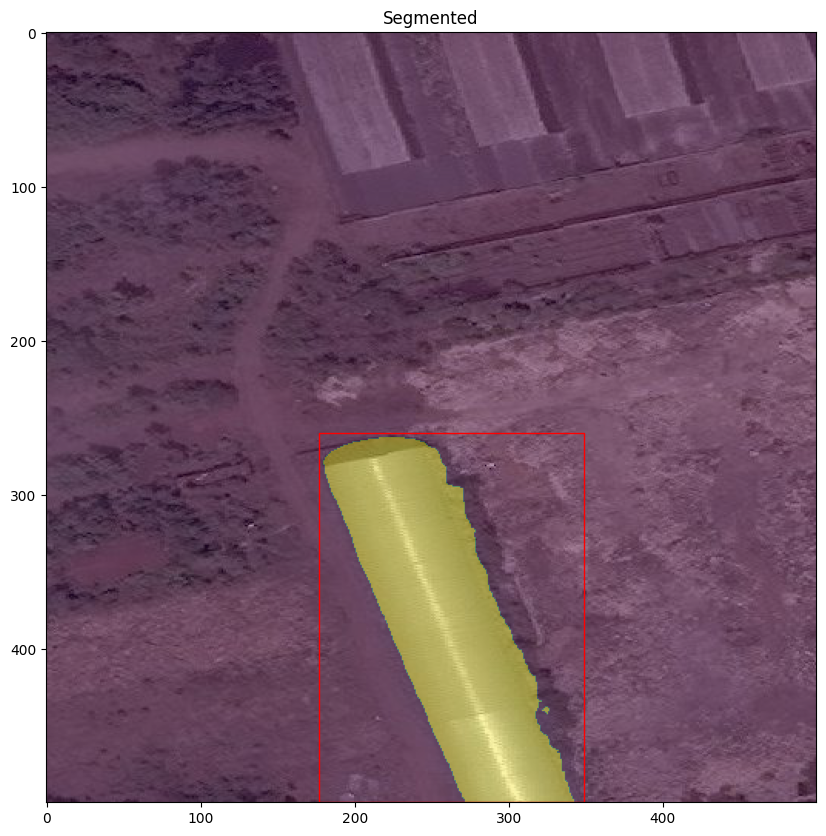

In [ ]:
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt, box_threshold=0.3, text_threshold=0.3)  # Customize the box and text threshold values to your data

if boxes.nelement() == 0:  # No "object" instances found
    print('No objects found in the image.')
else:
    # Create an empty image to store the mask overlays
    mask_overlay = np.zeros_like(image_np[..., 0], dtype=np.uint8)  # Adjusted for single channel

    for i, (box, mask) in enumerate(zip(boxes, masks)):
        # Convert tensor to numpy array if necessary and ensure it contains integers
        if isinstance(mask, torch.Tensor):
          mask = mask.cpu().numpy().astype(np.uint8)  # If mask is on GPU, use .cpu() before .numpy()
        mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)  # Assign a unique value for each mask

    # Normalize mask_overlay to be in [0, 255]
    mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

    # Display the original image with all mask overlays and bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)

    for box in boxes:
        # Draw bounding box
        box = box.cpu().numpy()  # Convert the tensor to a numpy array
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    plt.imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
    plt.title(f"Segmented")
    plt.show()

### Bounding Boxes Prompt

In [ ]:
boxes = np.array(example["objects"]["bbox"])
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
boxes = boxes.clip(0, 500)
boxes = torch.tensor(boxes).to(model.device)

In [ ]:
masks = model.predict_sam_box(image_pil, boxes)
masks = masks.squeeze(1)

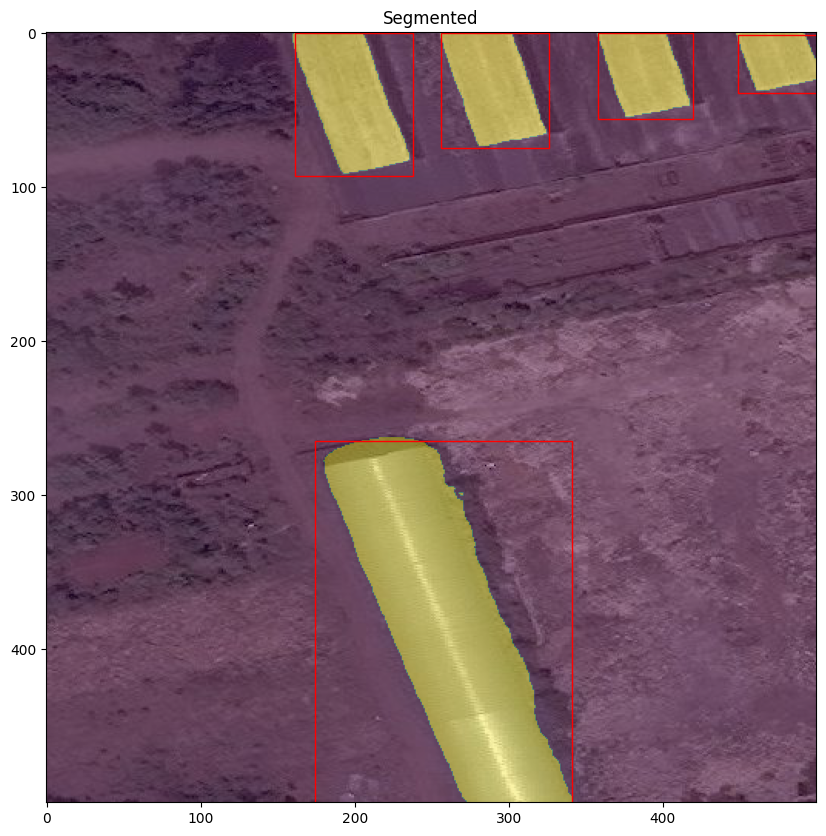

In [ ]:
# Create an empty image to store the mask overlays
mask_overlay = np.zeros_like(image_np[..., 0], dtype=np.uint8)  # Adjusted for single channel

for i, (box, mask) in enumerate(zip(boxes, masks)):
    # Convert tensor to numpy array if necessary and ensure it contains integers
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy().astype(np.uint8)  # If mask is on GPU, use .cpu() before .numpy()
    mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)  # Assign a unique value for each mask

# Normalize mask_overlay to be in [0, 255]
mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

# Display the original image with all mask overlays and bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_pil)

for box in boxes:
    # Draw bounding box
    box = box.cpu().numpy()  # Convert the tensor to a numpy array
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
plt.title(f"Segmented")
plt.show()

### Points Prompt

In [ ]:
# points = [(box[0] + 0.5 * box[2], box[1] + 0.5 * box[3]) for box in example["objects"]["bbox"]]
points = [(300, 450), (270, 400), (250, 350), (220, 300), (200, 450), (200, 400), (300, 300), (320, 300), (100, 400), (100, 300), (400, 300), (100, 200), (100, 100)]
labels = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels = torch.tensor(labels).unsqueeze(dim=1).to(model.device)
points = torch.tensor(points).unsqueeze(dim=1).to(model.device)

In [ ]:
masks = model.predict_sam_points(image_pil, points, labels)
masks = masks.squeeze(1)

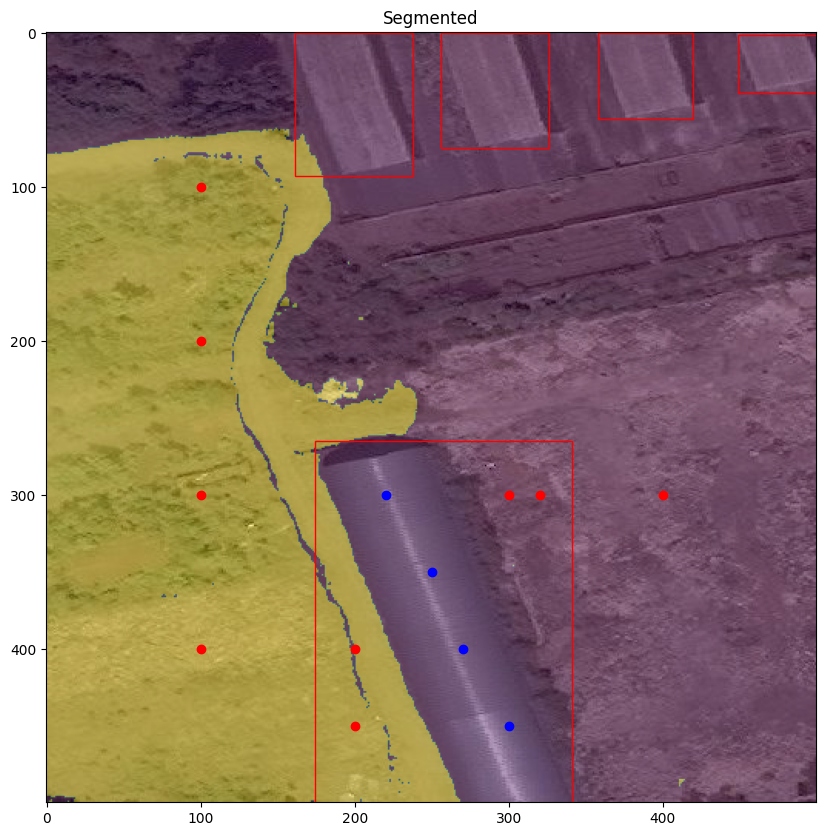

In [ ]:
# Create an empty image to store the mask overlays
mask_overlay = np.zeros_like(image_np[..., 0], dtype=np.uint8)  # Adjusted for single channel

for i, (box, mask) in enumerate(zip(boxes, masks)):
    # Convert tensor to numpy array if necessary and ensure it contains integers
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy().astype(np.uint8)  # If mask is on GPU, use .cpu() before .numpy()
    mask_overlay += ((mask > 0) * (i + 1)).astype(np.uint8)  # Assign a unique value for each mask

# Normalize mask_overlay to be in [0, 255]
mask_overlay = (mask_overlay > 0) * 255  # Binary mask in [0, 255]

# Display the original image with all mask overlays and bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_pil)

for box in boxes:
    # Draw bounding box
    box = box.cpu().numpy()  # Convert the tensor to a numpy array
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

reg_points = points.squeeze(dim=1).cpu()
reg_labels = labels.squeeze(dim=1).cpu()
for pt, lbl in zip(reg_points, reg_labels):
    style = "bo" if lbl == 1 else "ro"
    plt.plot(pt[0], pt[1], style)

plt.imshow(mask_overlay, cmap='viridis', alpha=0.4)  # Overlay the mask with some transparency
plt.title(f"Segmented")
plt.show()